# Week 4 - RDD and Difference-in-Differences

This notebook implements different idntification strategies with the foal to identify the causal effect of fiscal rules on incentives to accumulate debt.

To investigate this we exploit a fiscal reform from 2001 in Italy which relaxed fiscal restraints for municipalities with less than 5000, following the analysis by [Grembi et al. (2016)](https://www.aeaweb.org/articles?id=10.1257/app.20150076#:~:text=Fiscal%20rules%20are%20laws%20aimed,them%20to%20discipline%20local%20governments.&text=We%20exploit%20the%20before%2Fafter,increases%20deficits%20and%20lowers%20taxes.).

In [2]:
# Common imports
import numpy as np
import os
import pandas as pd

# To plot pretty figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib notebook
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import seaborn as sns
sns.set_theme()
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings = lambda *a, **kw: None

# to make this notebook's output identical at every run
np.random.seed(42)

## Explore the Data

In [3]:
df = pd.read_stata('data/week04.dta')
df_labels = pd.read_stata('data/week04.dta', iterator=True).variable_labels()

In [4]:
df.head()

,anno,popcens,giovani,entratetotgen_pc,trafgrants_pc,spesecor_pc,spesecocap_pc,spesetotgen_pc,aliquota_ordinaria,imposte,...,postper2002_int2,postper2002_int3,postper2003,postper2003_int1,postper2003_int2,postper2003_int3,postper2004,postper2004_int1,postper2004_int2,postper2004_int3
0,1999.0,3967.0,0.143240,1294.426880,288.899109,595.293518,679.409302,1324.374756,0.65,88.360217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2000.0,3967.0,0.144753,1374.037354,261.448029,587.072388,744.917542,1376.292114,0.65,121.037560,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2001.0,4178.0,0.146581,1501.324585,322.154572,670.274170,788.040039,1499.372192,0.65,132.679365,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2002.0,4178.0,0.147371,1194.384766,316.933960,694.407593,464.735138,1195.435181,0.70,195.241282,...,675684.0,-555412224.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2003.0,4178.0,0.146598,1493.122559,301.837708,730.846252,719.933350,1488.273193,0.70,241.505226,...,0.0,0.0,1.0,-822.0,675684.0,-555412224.0,0.0,0.0,0.0,0.0


In [5]:
df_labels

{'anno': 'year',
 'popcens': 'census population',
 'giovani': 'youngsters',
 'entratetotgen_pc': '',
 'trafgrants_pc': '',
 'spesecor_pc': 'current outlays ',
 'spesecocap_pc': 'capital outlays',
 'spesetotgen_pc': '',
 'aliquota_ordinaria': 'real estate tax',
 'imposte': 'taxes',
 'tasse': 'fees and tariffs',
 'state_transfers': '',
 'aliquota_irpef': 'income tax surcharge ',
 'expend_interest_pc': 'debt service',
 'other_transfers': '',
 'entrate_altre_pc': 'other revenues',
 'saldofinanziario_pc': 'fiscal gap',
 'deficit_pc': 'deficit',
 'income': '',
 'area': 'central trasnfers',
 'number_parties': '',
 'college': '',
 'years_school': '',
 'term_limit': '',
 'gender': '',
 'age': '',
 'exp': '',
 'preexp': '',
 'centerright': '',
 'sealevel2': '',
 'north_est': '',
 'north_west': '',
 'south': '',
 'center': '',
 'mayoraliq': '',
 'youngvoters': '',
 'expcoref': '',
 'north': '',
 'id_comune': '',
 'id_codente': '',
 'treatment_t': '',
 'treatment_t_int1': '',
 'treatment_t_int2': 

We create 3 variables:

- $t5000$: dummy equal to 1 if the municipality has more than 5000 inhabitants
- $pop5000$: population centered at 5000
- $post$: dummy equal to 1 if the observation is after 2001

In [6]:
df['t5000'] = df['popcens']>5000
df['t5000'] = df['t5000'].astype(int)

df['pop5000'] = df['popcens'] - 5000

df['post'] = df['anno']>2000
df['post'] = df['post'].astype(int)


The dataset is a balanced panel of 1050 municipalities from 1999 to 2004. The main outcomes of interest we will use are the deficit (*deficit_pc*) and taxes (*imposte*) and we want to investigate the effect of having less than 5000 inhabitants (*t5000* is a dummy equal to 1 if the population is more than 5000) in the municipalities after 2001.

**Which identification strategy would you apply in this setting?**

It depends on which source of variation in the rule we want to exploit:

- If we want to exploit the discontinuity induced by the population threshold (5000 inhabitants) then we should use a regression discontinuity design;
- If we want to exploit the variation induced by the introduction of the reform in 2001 then we should use a difference-in-differences design

The question on which design is the best one to estimate the causal effect in this setting depends on whether the assumption underlying each design hold, and we will investigate this in the notebook.

## Regression Discontinuity Design

In this first part we exploit the discontinuity in fiscal rules imposed by the reform. Namely, we investigate the difference in the outcomes of interest betweem municipalities at different sides of the cutoff **after** 2001. The regression that we are going to estimate is:


<center>$y_i = \beta_0 + \beta_1 pop5000_i + t5000_i(\gamma_0 + \gamma_1 pop5000_i) + \varepsilon_i$</center>

In [7]:
from rdrobust import rdrobust, rdbwselect, rdplot

margin = df[df['anno']>2000].pop5000
outcome = [df[df['anno']>2000].deficit_pc, df[df['anno']>2000].imposte]

for y in outcome:
    print(rdrobust(y=y, x=margin, p=3, vce='hc1'))

Mass points detected in the running variable.
Mass points detected in the running variable.
Call: rdrobust
Number of Observations:                  4200
Polynomial Order Est. (p):                  3
Polynomial Order Bias (q):                  4
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

                                Left      Right
------------------------------------------------
Number of Observations          2220       1980
Number of Unique Obs.            458        435
Number of Effective Obs.        1100        904
Bandwidth Estimation           743.3      743.3
Bandwidth Bias               992.766    992.766
rho (h/b)                      0.749      0.749

Method             Coef.     S.E.   t-stat    P>|t|       95% CI      
-------------------------------------------------------------------------
Conventional      -5.547   10.724   -0.517   6.050e-01  [-26.566, 15.472]
Robust     

Mass points detected in the running variable.


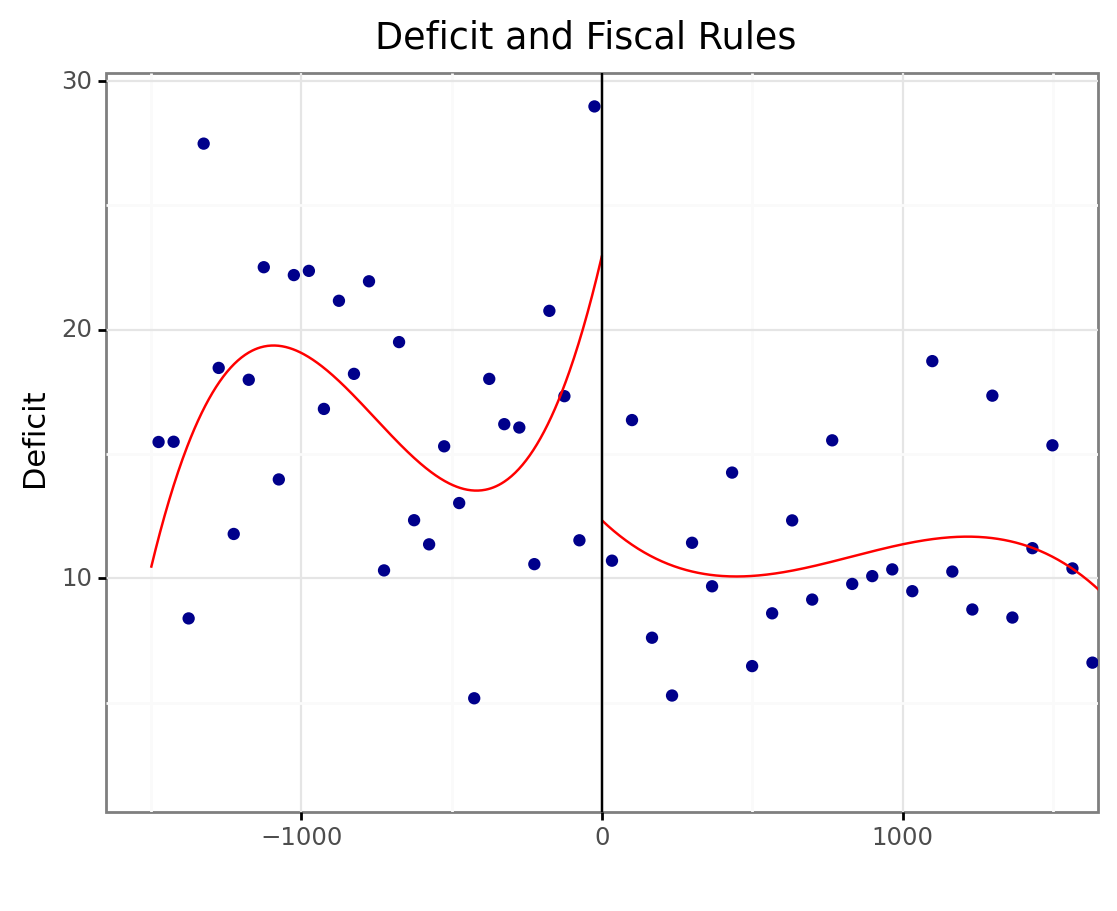


Call: rdplot
Number of Observations:                  4200
Kernel:                               Uniform
Polynomial Order Est. (p):                  3

                                Left      Right
------------------------------------------------
Number of Observations          2220       1980
Number of Effective Obs         2220       1980
Bandwith poly. fit (h)        1500.0     1998.0
Number of bins scale               1          1
Bins Selected                     30         30
Average Bin Length              50.0       66.6
Median Bin Length               50.0       66.6
IMSE-optimal bins                5.0        5.0
Mimicking Variance bins         59.0       60.0

Relative to IMSE-optimal:
Implied scale                    6.0        6.0
WIMSE variance weight          0.005      0.005
WIMSE bias weight              0.995      0.995


In [8]:
rdplot(y=outcome[0], x=margin, nbins=30, masspoints='adjust', p=3,
         title="Deficit and Fiscal Rules", 
         y_label="Deficit",
         x_label=" ", x_lim=[-1500, 1500])

Mass points detected in the running variable.


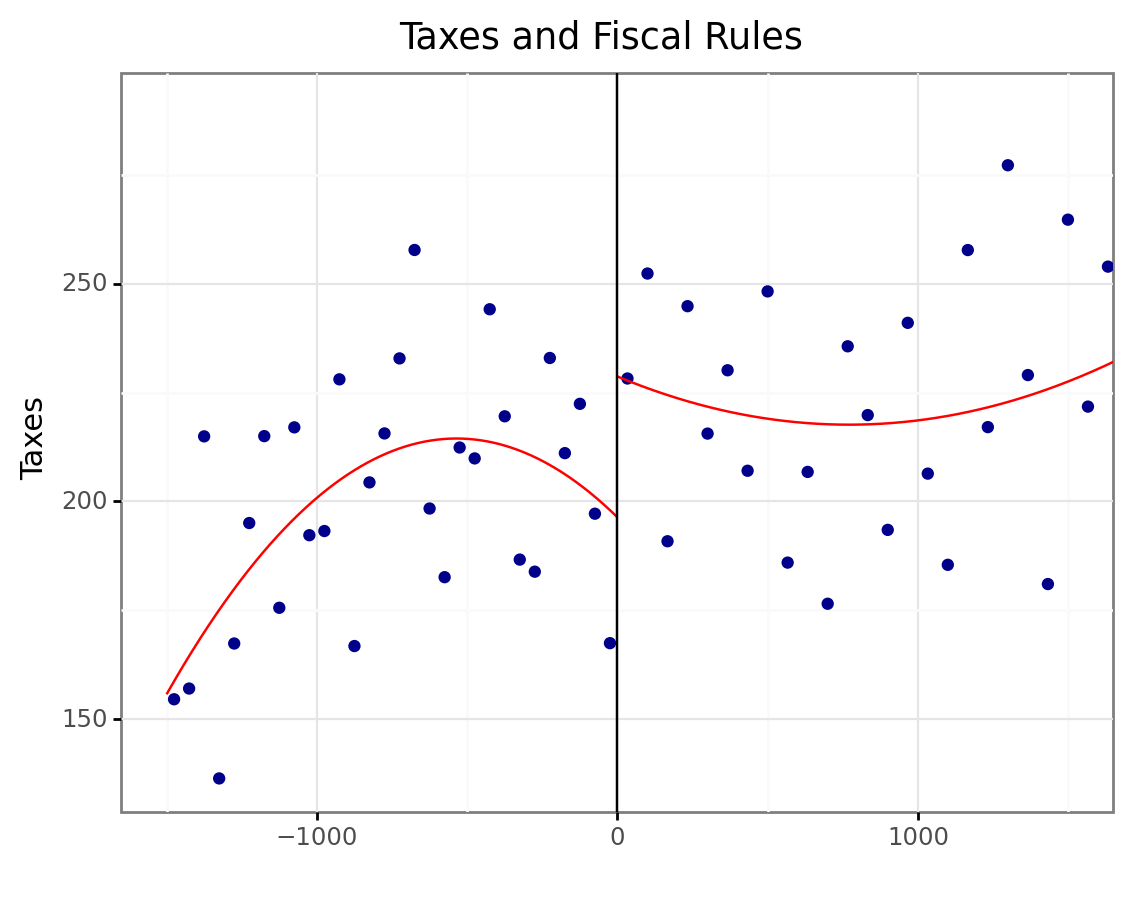


Call: rdplot
Number of Observations:                  4200
Kernel:                               Uniform
Polynomial Order Est. (p):                  2

                                Left      Right
------------------------------------------------
Number of Observations          2220       1980
Number of Effective Obs         2220       1980
Bandwith poly. fit (h)        1500.0     1998.0
Number of bins scale               1          1
Bins Selected                     30         30
Average Bin Length              50.0       66.6
Median Bin Length               50.0       66.6
IMSE-optimal bins                8.0        6.0
Mimicking Variance bins         63.0       62.0

Relative to IMSE-optimal:
Implied scale                   3.75        5.0
WIMSE variance weight          0.019      0.008
WIMSE bias weight              0.981      0.992


In [9]:
rdplot(y=outcome[1], x=margin, nbins=30, p=2, masspoints='adjust',
         title="Taxes and Fiscal Rules", 
         y_label="Taxes",
         x_label=" ", x_lim=[-1500, 1500])

**Interpretation:** On average, municipalities with less than 5000 inhabitants with less strict fiscal constraints have deficit larger than municipalities with stricter constraints by 5.5 euros per capita and tax revenues lower by 69.5 euros.

**What is the main assumption behind a causal interpretation of this effect? What are two ways to test this assumption?**

The main assumption that must be satisfied for this estimate to be causal is that observations around the cutoff must be as good as randomly assigned. 

The first thing we need to check for this to be true is that there is no manipulation at the cutoff. In this case, this means that municipalities with population larger or lower by a little than 5000 cannot manipulate their population record in order to be on either side of the cutoff. This can be tested with a density plot of the running variable: if there is no (or little) difference between the density of observations close to the cutoff, then this assumption is satisfied. 

The second thing we need to check is that there is no jump at the cutoff in other pre-determined variables. In this case the variable we can look at are geographic variables and in particular the location of the municipality within Italy (north vs south). To test this assumption we can run the analysis above using as the pre-determined variables as outcomes.

**No Manipulation at the Cutoff**

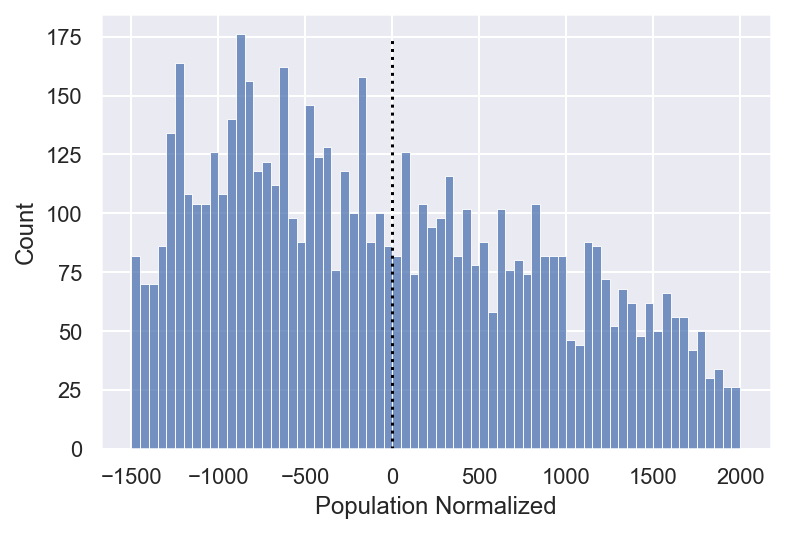

In [10]:
plot = sns.histplot(data=df, x='pop5000', binwidth=50)
plot.set(xlabel='Population Normalized', ylabel='Count')
plot.vlines(0, 0, 175, color='black', linestyle='dotted')
plt.show()

**No Discontinuities in Covariates**

Mass points detected in the running variable.


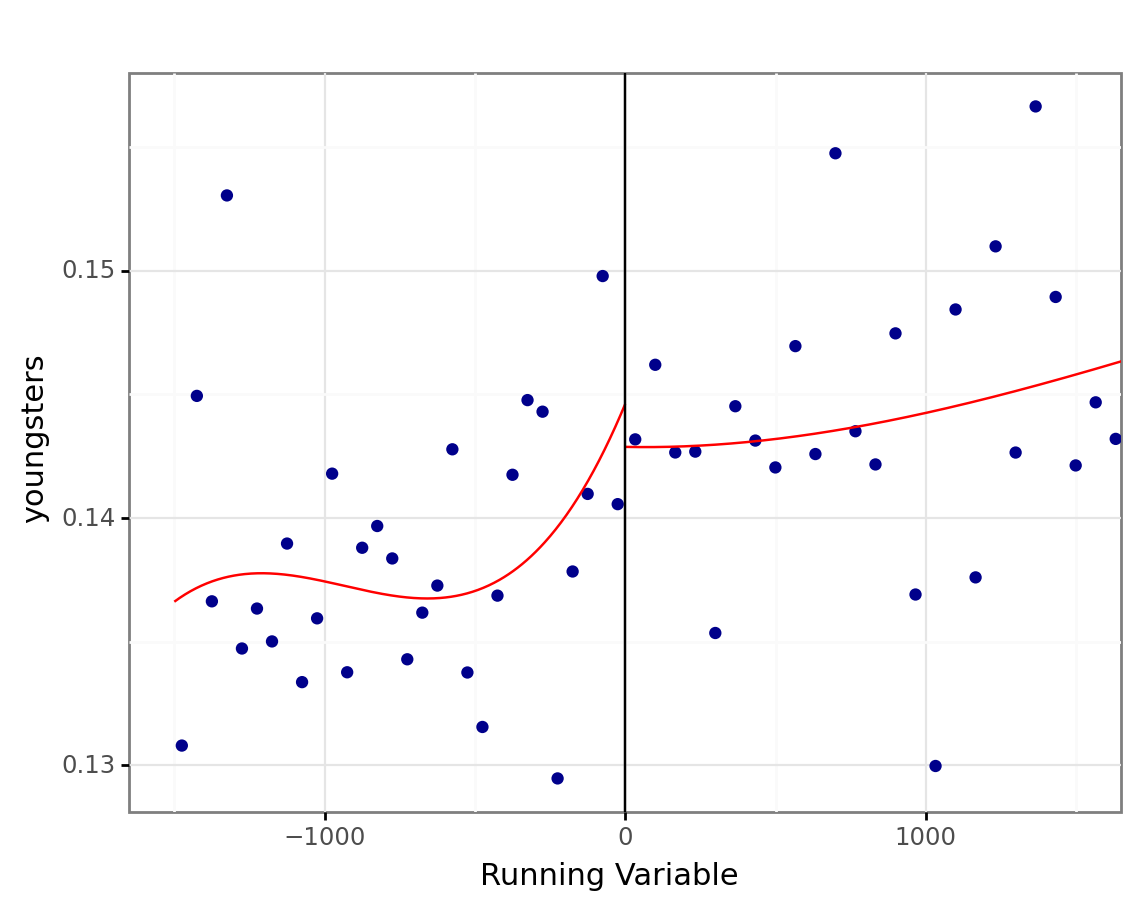


Mass points detected in the running variable.


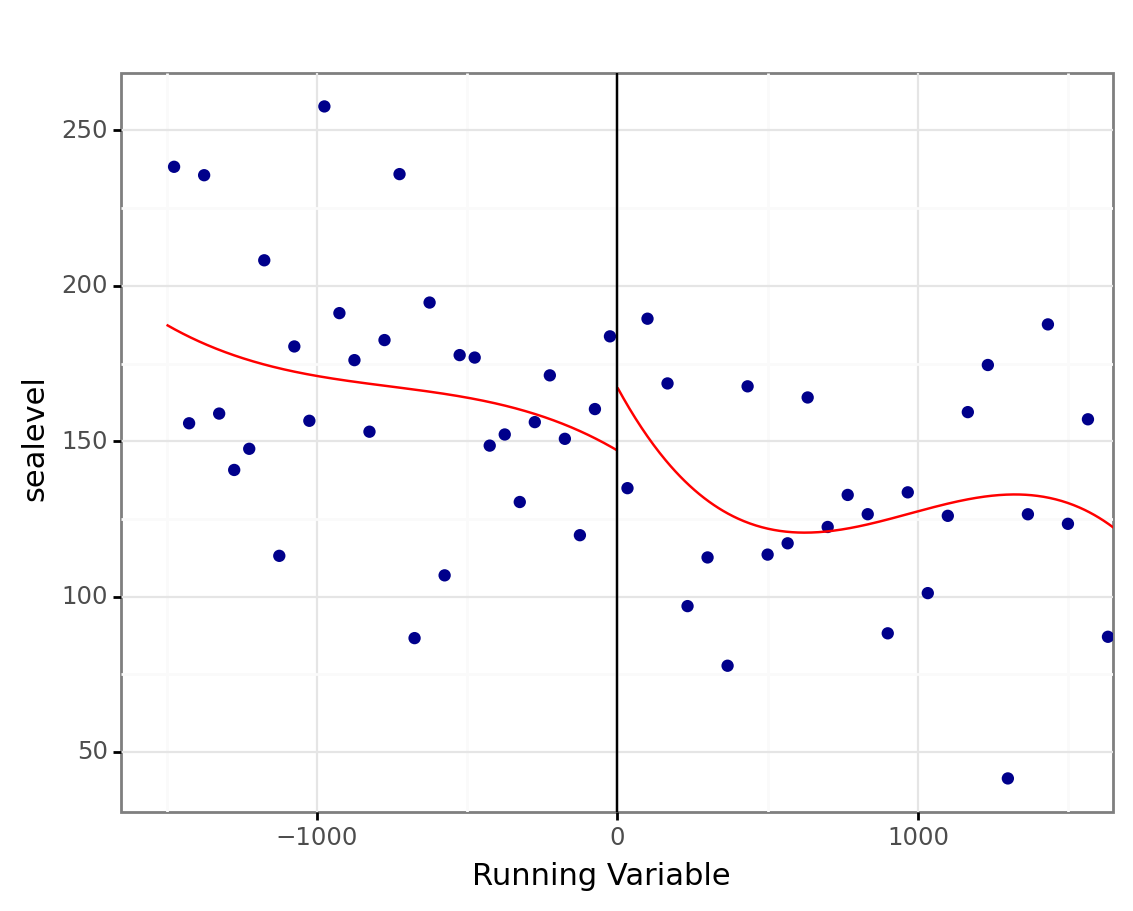


Mass points detected in the running variable.


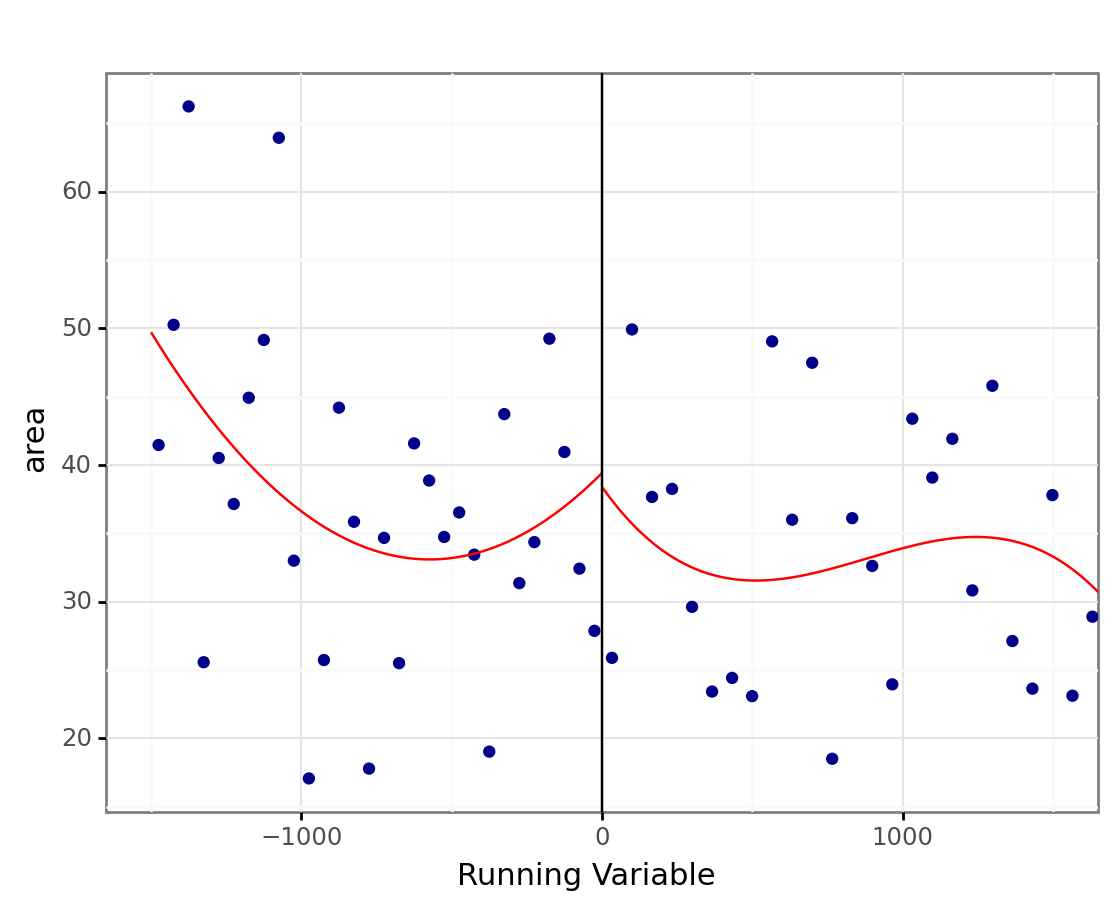


Mass points detected in the running variable.


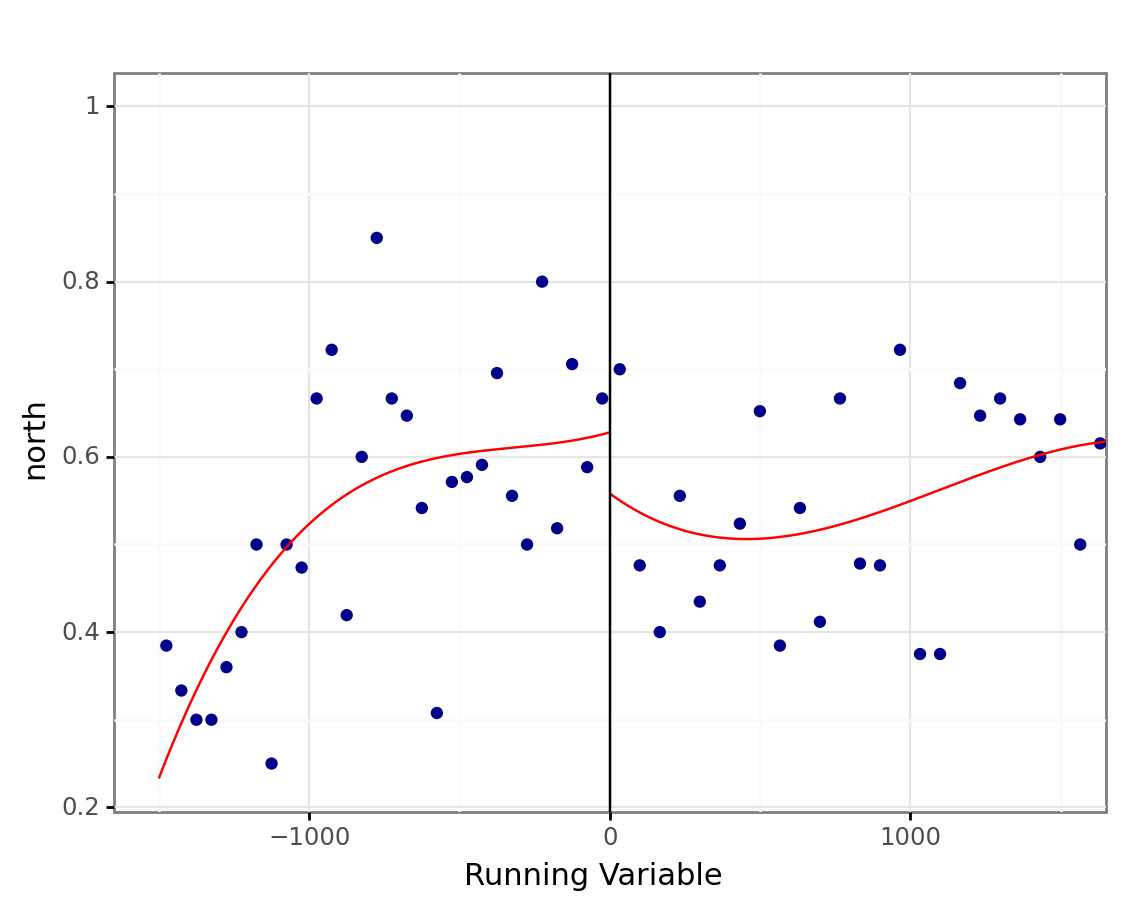


Mass points detected in the running variable.


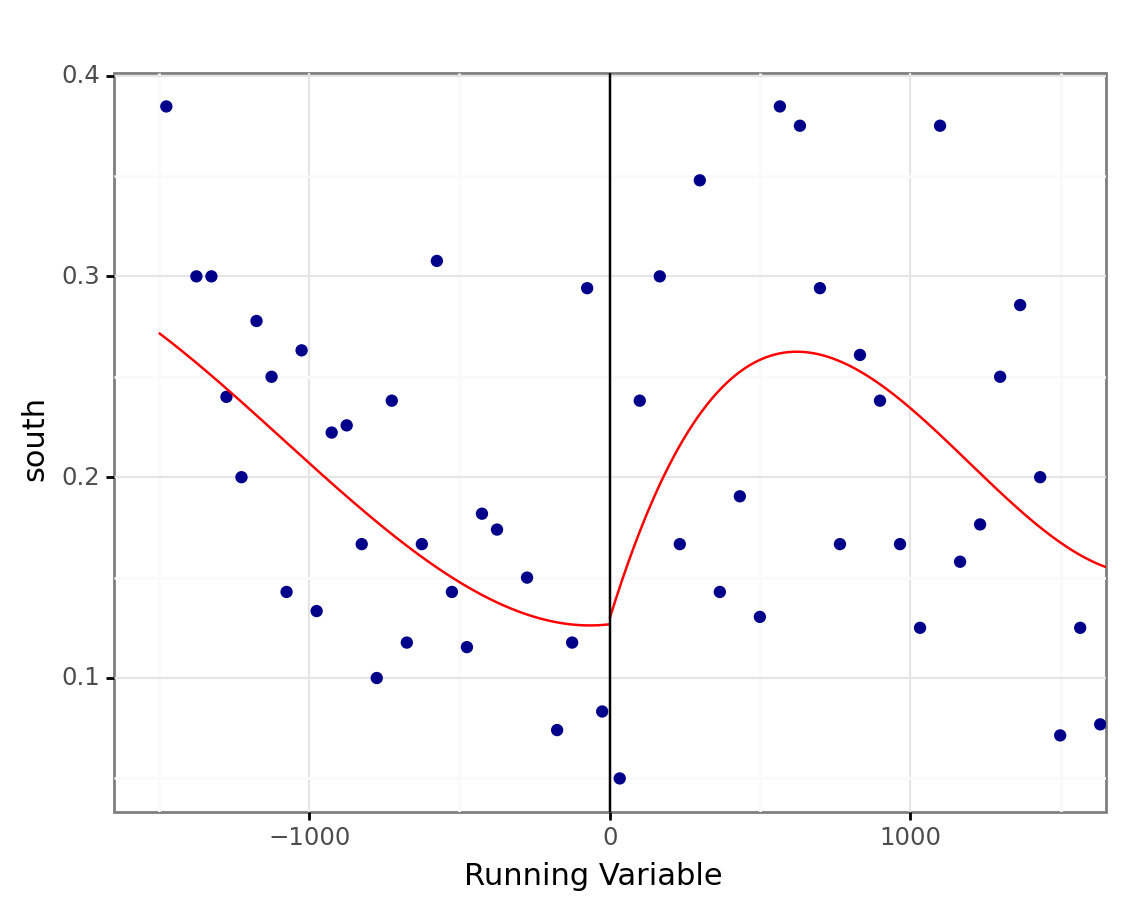

In [11]:
cov_names = ['youngsters', 'sealevel', 'area', 'north', 'south']
covariates = [df[df['anno']>2000].giovani, df[df['anno']>2000].sealevel2, df[df['anno']>2000].area, df[df['anno']>2000].north, df[df['anno']>2000].south]

for i in range(0, len(cov_names)): 
    rdplot(y=covariates[i], x=margin, nbins=30, masspoints='adjust', p=3,
         title=" ", 
         y_label=cov_names[i],
         x_label="Running Variable", x_lim=[-1500, 1500])

**Are these assumptions satisfied? What other threats to a causality do you see here?**

These assumptions seem to hold in this case. However, there is one factor that confounds this effect. In Italy there is another rule that exploits the 5000 population threshold, which has been in place since before 2001. This rule implies small municipalities elect their mayor with one-shot elections, while in big municipalities if the mayor does not reach more than 50% consensus there must be a second round of elections between the two most popular candidates. The RDD does not allow us to disentangle the effect between this rule and the fiscal reform, preventing us from causally interpret the results. 

## Difference-in-Differences

Now instead of exploiting the discontinuity at 5000 inhabitants we exploit date of implementation of the reform. The regression of interest is the following: 

$y_{i,t} = \beta_0 + \beta_1 t5000_{i} + \beta_2 post_{t} + \beta_3 t5000_i * post_t + \varepsilon_{i,t}$

or alternatively, using time and municipality fixed effects:

$y_{i,t} = \beta_0 + \alpha_i + \delta_t + \beta_3 t5000_i * post_t + \varepsilon_{i,t}$

In [12]:
df['t5000'] = df['popcens']<=5000
df['t5000'] = df['t5000'].astype(int)

df['tpost'] = df['t5000']*df['post']

In [14]:
from linearmodels import PanelOLS

df_did = df.set_index(['id_comune', 'anno'])
did_deficit = PanelOLS(df_did.deficit_pc, df_did.tpost, entity_effects=True, time_effects=True).fit(cov_type = 'clustered', cluster_entity=True)
did_deficit

Dep. Variable:,deficit_pc,R-squared:,0.0007
Estimator:,PanelOLS,R-squared (Between):,0.0863
No. Observations:,6300,R-squared (Within):,0.0004
Date:,"Sun, Oct 24 2021",R-squared (Overall):,0.0191
Time:,17:48:22,Log-likelihood,-3.306e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,3.8251
Entities:,1050,P-value,0.0505
Avg Obs:,6.0000,Distribution:,"F(1,5244)"
Min Obs:,6.0000,,
Max Obs:,6.0000,F-statistic (robust):,6.0061


In [15]:
did_taxes = PanelOLS(df_did.imposte, df_did.tpost, entity_effects=True, time_effects=True).fit(cov_type = 'clustered', cluster_entity=True)
did_taxes

Dep. Variable:,imposte,R-squared:,0.0036
Estimator:,PanelOLS,R-squared (Between):,-0.0250
No. Observations:,6300,R-squared (Within):,-0.0450
Date:,"Sun, Oct 24 2021",R-squared (Overall):,-0.0266
Time:,17:51:48,Log-likelihood,-3.096e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,19.153
Entities:,1050,P-value,0.0000
Avg Obs:,6.0000,Distribution:,"F(1,5244)"
Min Obs:,6.0000,,
Max Obs:,6.0000,F-statistic (robust):,7.3518


**Interpretation:** Let us focus on deficit. Municipalities with less strict fiscal rules have a larger deficit by 5.3 euros per capita than municipalities with more than 5000 inhabitants in the period before the reform. 

**What is the main assumption that allows for a causal interpretation of these results? How can we test it?**

The main assumption underlying the difference-in-differences design is the parallel trends assumption. This entails that **before** the policy was implemented municipalities with population above or below the threshold should display the same trend in public finance outcomes. We can test this hypothesis by plotting the time series fo the outcomes separately for treated and untreated municipalities.

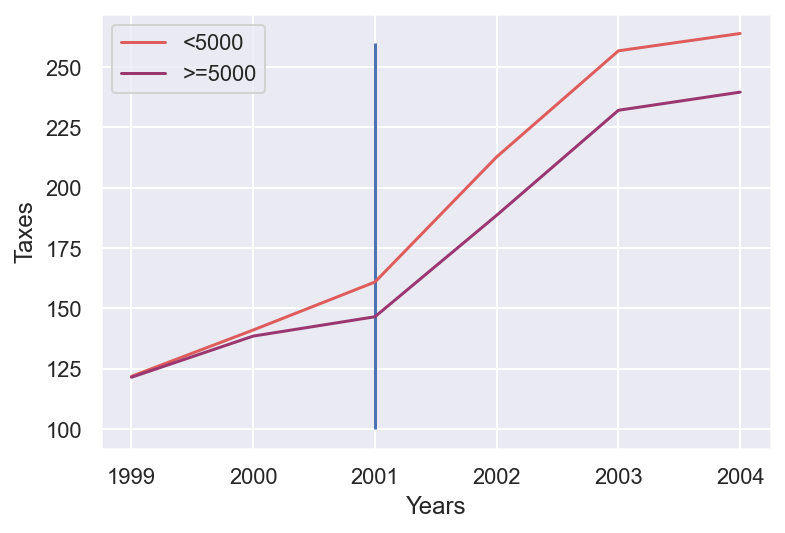

In [16]:
palette = sns.color_palette("flare", 2)
plot = sns.lineplot(data=df, x='anno', y='imposte', hue='t5000', palette=palette, ci=None)
plot.set(xlabel='Years', ylabel='Taxes')
plot.legend_.set_title('')
new_labels = ['<5000', '>=5000']
for t, l in zip(plot.legend_.texts, new_labels):
    t.set_text(l)
plt.vlines(2001, 100, 260)
plt.show()

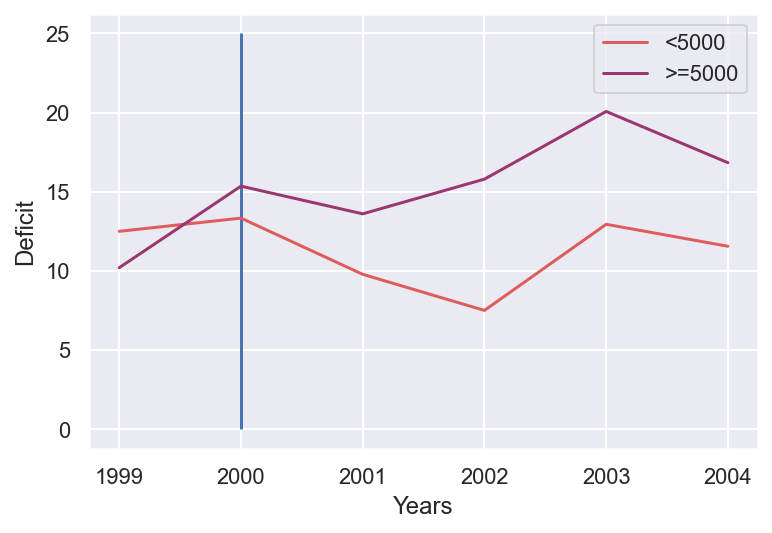

In [17]:
palette = sns.color_palette("flare", 2)
plot = sns.lineplot(data=df, x='anno', y='deficit_pc', hue='t5000', palette=palette, ci=None)
plot.set(xlabel='Years', ylabel='Deficit')
plot.legend_.set_title('')
new_labels = ['<5000', '>=5000']
for t, l in zip(plot.legend_.texts, new_labels):
    t.set_text(l)
plt.vlines(2000, 0, 25)
plt.show()


**Is it satisfied?**

It does seem to hold for taxes, but it surely does not hold for deficit. In any case, it is unlikely that very small municipalities have public finance trends similar to those of big municipalities. So also the DiD estimate cannot be interpreted as causal. 

## The Author's solution: Difference in Discontinuities

This method exploits both the discontinuous variation at 5000 inhabitants and the time variation for the introduction of the policy. 

**Step 1:** Estimate the optimal bandwidth for the period *before* and *after* 2001 and take the average between the two.

In [18]:
margin = df[df['anno']<2001].pop5000
outcome = [df[df['anno']<2001].deficit_pc, df[df['anno']<2001].imposte]

for y in outcome:
    print(rdbwselect(y=y, x=margin, p=2, vce='hc1'))

Mass points detected in the running variable.
Call: rdbwselect
Number of Observations:                  2100
Polynomial Order Est. (p):                  2
Polynomial Order Bias (q):                  3
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

       h (left)  h (right)  b (left)  b (right)
mserd    699.47     699.47   895.837    895.837

Mass points detected in the running variable.
Call: rdbwselect
Number of Observations:                  2100
Polynomial Order Est. (p):                  2
Polynomial Order Bias (q):                  3
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

       h (left)  h (right)  b (left)  b (right)
mserd    653.68     653.68  1080.251   1080.251



In [19]:
margin = df[df['anno']>2000].pop5000
outcome = [df[df['anno']>2000].deficit_pc, df[df['anno']>2000].imposte]

for y in outcome:
    print(rdbwselect(y=y, x=margin, p=2, vce='hc1'))

Mass points detected in the running variable.
Call: rdbwselect
Number of Observations:                  4200
Polynomial Order Est. (p):                  2
Polynomial Order Bias (q):                  3
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

       h (left)  h (right)  b (left)  b (right)
mserd     589.1      589.1   847.597    847.597

Mass points detected in the running variable.
Call: rdbwselect
Number of Observations:                  4200
Polynomial Order Est. (p):                  2
Polynomial Order Bias (q):                  3
Kernel:                            Triangular
Bandwidth Selection:                    mserd
Var-Cov Estimator:                        HC1

       h (left)  h (right)  b (left)  b (right)
mserd   665.188    665.188    917.09     917.09



In [20]:
tax_bw = (653.68 + 665.188)/2
deficit_bw = (589.18 +699.47)/2

**Step 2:** Estimate the following regression **within** the optimal bandwidth, where the coefficient of interest is $(\alpha_0 + \beta_0)$:

<center>$y_{it} = \delta_0 + \delta_1 pop5000_i + t5000_i * (\gamma_0 + \gamma_1 pop5000_i) + post_t (\alpha_0 + \alpha_1 pop5000_i + t5000_i (\beta_0 + \beta_1 pop5000_i)) + \varepsilon_{i,t}$</center>

In [21]:
import statsmodels.api as sm

df['tpop5000'] = df['t5000']*df['pop5000']
df['post_pop5000'] = df['post']*df['pop5000']
df['post_tpop5000'] = df['t5000']*df['pop5000']*df['post']
expl = ['tpost','tpop5000', 'post_pop5000', 'post_tpop5000', 'pop5000', 't5000', 'post']


df_did = df[df['pop5000'].abs()<deficit_bw].set_index(['id_comune', 'anno'])

expl_var = sm.add_constant(df_did[expl])

dic_deficit = PanelOLS(df_did.deficit_pc, expl_var).fit(cov_type = 'clustered', cluster_entity=True)
dic_deficit

Dep. Variable:,deficit_pc,R-squared:,0.0034
Estimator:,PanelOLS,R-squared (Between):,0.0216
No. Observations:,2648,R-squared (Within):,0.0008
Date:,"Fri, Oct 22 2021",R-squared (Overall):,0.0034
Time:,09:57:06,Log-likelihood,-1.422e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,1.2844
Entities:,562,P-value,0.2538
Avg Obs:,4.7117,Distribution:,"F(7,2640)"
Min Obs:,2.0000,,
Max Obs:,6.0000,F-statistic (robust):,1.7618


In [22]:
df_did = df[df['pop5000'].abs()<tax_bw].set_index(['id_comune', 'anno'])

expl_var = sm.add_constant(df_did[expl])

dic_taxes = PanelOLS(df_did.imposte, expl_var).fit(cov_type = 'clustered', cluster_entity=True)
dic_taxes

Dep. Variable:,imposte,R-squared:,0.1440
Estimator:,PanelOLS,R-squared (Between):,0.1217
No. Observations:,2728,R-squared (Within):,0.3377
Date:,"Fri, Oct 22 2021",R-squared (Overall):,0.1440
Time:,09:57:11,Log-likelihood,-1.649e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,65.379
Entities:,576,P-value,0.0000
Avg Obs:,4.7361,Distribution:,"F(7,2720)"
Min Obs:,2.0000,,
Max Obs:,6.0000,F-statistic (robust):,85.757
